In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)
num_train=mnist.train.num_examples
num_val=mnist.validation.num_examples
num_test=mnist.test.num_examples

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [3]:
# predefined parameters
channel=1
height=28
width=28
patch=7
n_glimpse=15
lstm_hidden_dim=256
latent_dim=512
eps=1e-10

In [4]:
tf.reset_default_graph()


def decode_attention_para(hidden_decode,paser):
    '''
    calculate parameters(gx,gy,sigma,stride,gamma) from h_dec
    each is (batch,1) tensor
    '''
    paras=paser(hidden_decode)
    gx,gy,sigma,stride,gamma=tf.split(paras,[1,1,1,1,1],axis=1)
    gx=(gx+1.0)*(width+1)/2.0
    gy=(gy+1.0)*(height+1)/2.0
    sigma=tf.exp(sigma)
    stride=tf.exp(stride)*(max(width,height)-1.0)/(patch-1.0)
    gamma=tf.exp(gamma)
    return gx,gy,sigma,stride,gamma


def filterbank(batch_size,gx,gy,sigma,stride):
    '''
    calculate filterbank FX and FY using parameters
    shape of FX is (batch,channel,patch,width), each tensor in axis=3 is gaussian distribution centered at gx and scale is sigma
    shape of FY is (batch,channel,patch,height), similar to FX
    '''
    # initialize FY, shape=(batch,patch,height), value is multipling range(height) for (batch*patch) times
    FY=tf.tile(tf.reshape(tf.range(height,dtype=tf.float32),(1,1,height)),multiples=(batch_size,patch,1))
    # center position, shape=(batch,patch), value is like (-2stride+gy,-stride+gy,gy,stride+gy,2stride+gy) for all batches
    py=tf.tile(tf.reshape(tf.range(patch,dtype=tf.float32)-(patch-1)//2,(1,patch)),multiples=(batch_size,1))*stride+gy
    # gaussian distribution of FY, shape is the same as FY, value is gaussian for all batches
    FY=tf.exp(-tf.square(FY-tf.reshape(py,(-1,patch,1)))/2.0*tf.reshape(sigma,(-1,1,1)))   # modified
    # normalized FY, shape=(batch,patch,height), each vector is sumed to 1
    FY/=(eps+tf.reduce_sum(FY,axis=2,keep_dims=True))   # modified: add eps for numerical stability
    # copy through all channels, shape=(batch,channel,patch,height)
    FY=tf.tile(tf.reshape(FY,[-1,1,patch,height]),(1,channel,1,1))
    
    FX=tf.tile(tf.reshape(tf.range(width,dtype=tf.float32),(1,1,width)),multiples=(batch_size,patch,1))
    px=tf.tile(tf.reshape(tf.range(patch,dtype=tf.float32)-(patch-1)//2,(1,patch)),multiples=(batch_size,1))*stride+gx
    FX=tf.exp(-tf.square(FX-tf.reshape(px,(-1,patch,1)))/2.0*tf.reshape(sigma,(-1,1,1)))   # modified
    FX/=(eps+tf.reduce_sum(FX,axis=2,keep_dims=True))   # modified
    FX=tf.tile(tf.reshape(FX,[-1,1,patch,width]),(1,channel,1,1))
    return FX,FY

def read(image,FX,FY,gamma):
    '''
    Inputs:
    image, shape=(batch,channel,height,width)
    filterbank FX, shape=(batch,channel,patch,width)
    filterbank FY, shape=(batch,channel,patch,height)
    scale intensity gamma, shape=(batch,1)
    
    Outputs:
    encoded patch, shape=(batch,channel*patch*patch)
    '''
    patch_image=tf.matmul(tf.matmul(FY,X),FX,transpose_b=True)*tf.reshape(gamma,(-1,1,1,1))
    patch_image=tf.layers.flatten(patch_image)
    return patch_image
    
def write(pat,batch_size,FX,FY,gamma):
    '''
    Inputs:
    pat, patch decode from hidden, shape=(batch,channel*patch*patch)
    filterbank FX, shape=(batch,channel,patch,width)
    filterbank FY, shape=(batch,channel,patch,height)
    scale intensity gamma, shape=(batch,1)
    
    Outputs:
    decoded image, shape=(batch,channel,height,width)
    '''
    pat=tf.reshape(pat,(batch_size,channel,patch,patch))
    reconstruct_image=tf.matmul(tf.matmul(FY,pat,transpose_a=True),FX)/tf.reshape(gamma,(-1,1,1,1))
    return reconstruct_image

def logistic_likelihood(original_image,recon_image):
    return -(original_image*tf.log(eps+recon_image)+(1.0-original_image)*tf.log(1.0-recon_image))


# input
X=tf.placeholder(shape=[None,channel,height,width],dtype=tf.float32,name='input_image')
batch_size=tf.shape(X)[0]
canvas=tf.zeros(shape=[batch_size,channel,height,width],dtype=tf.float32,name='output_canvas')

READ_attention_paras=tf.layers.Dense(units=5,name='attention_para_read')   # calculate parameters for READ operation
WRITE_attention_paras=tf.layers.Dense(units=5,name='attention_para_write')   # calculate parameters for WRITE operation
WRITE_patch=tf.layers.Dense(units=channel*patch*patch,name='patch_write')   # calculate patch_image for WRITE operation
encoder_lstm=tf.contrib.rnn.LSTMCell(lstm_hidden_dim)
decoder_lstm=tf.contrib.rnn.LSTMCell(lstm_hidden_dim)
init_state_encode=encoder_lstm.zero_state(batch_size, tf.float32)   # lstm tuple (c,h)
init_state_decode=decoder_lstm.zero_state(batch_size, tf.float32)   # lstm tuple (c,h)
state_encode=None
state_decode=None
encoder_mean=tf.layers.Dense(units=latent_dim,name='encoder_mean')   # calculate mean of z
encoder_std=tf.layers.Dense(units=latent_dim,name='encoder_std')   # calculate std of z
unit_gaussian=tf.distributions.Normal(loc=tf.zeros(latent_dim),scale=tf.ones(latent_dim),name='unit_norm')

read_paras_his=[]
write_paras_his=[]
canvas_his=[]
latent_loss_his=[]
likelihood_loss_his=[]

for t in range(n_glimpse):
    error_image=X-canvas
    previous_hidden_decode=init_state_decode[1] if t==0 else state_decode[1]
    gx,gy,sigma,stride,gamma=decode_attention_para(previous_hidden_decode,READ_attention_paras)
    read_paras_his.append((gx,gy,stride,sigma))
    FX,FY=filterbank(batch_size,gx,gy,sigma,stride)
    patch_image=read(X,FX,FY,gamma)
    patch_error_image=read(error_image,FX,FY,gamma)
    encoder_input=tf.concat([patch_image,patch_error_image,previous_hidden_decode],axis=1)
    with tf.variable_scope("LSTM_encoder") as vs:
        encoder_out,state_encode=encoder_lstm(encoder_input,init_state_encode if t==0 else state_encode)
    z_mean=encoder_mean(encoder_out)
    z_std=tf.exp(encoder_std(encoder_out))
    distrib_encode=tf.distributions.Normal(loc=z_mean,scale=z_std)
    Z=distrib_encode.sample()
    
    latent_loss=tf.reduce_sum(tf.distributions.kl_divergence(distrib_encode,unit_gaussian),axis=1)
    latent_loss_his.append(latent_loss)
    
    with tf.variable_scope("LSTM_decoder") as vs:
        decoder_out,state_decode=decoder_lstm(Z,init_state_decode if t==0 else state_decode)
    _gx,_gy,_sigma,_stride,_gamma=decode_attention_para(decoder_out,WRITE_attention_paras)
    write_paras_his.append((_gx,_gy,_stride,_sigma))
    new_patch_image=WRITE_patch(decoder_out)
    _FX,_FY=filterbank(batch_size,_gx,_gy,_sigma,_stride)
    added_image=write(new_patch_image,batch_size,_FX,_FY,_gamma)
    canvas+=added_image
    
    canvas_his.append(canvas)
    
total_latent_loss=tf.reduce_mean(latent_loss_his)
total_likelihood_loss=tf.reduce_mean(tf.reduce_sum(tf.square(tf.layers.flatten(X)-tf.layers.flatten(canvas)),axis=1))
total_loss=total_latent_loss+total_likelihood_loss

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 4e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,num_train//128, 0.9, staircase=True)
optimizier=tf.train.RMSPropOptimizer(learning_rate=starter_learning_rate)
train_step = optimizier.minimize(total_loss,global_step=global_step)

In [5]:
batch_size=128
max_epoch=100
print_every=50
num_iteration=num_train//batch_size
loss_train_his=[]
loss_val_his=[]
loss_test_his=[]

def eval(dataset,num_iteration):
    t_loss=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        loss_num = sess.run(total_loss,feed_dict={X:images.reshape((-1,1,28,28))})
        t_loss+=loss_num
    t_loss/=num_iteration
    return t_loss

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'start epoch %d/%d, with learning rate = %.10f' % (epoch+1,max_epoch,sess.run(learning_rate)))
        average_loss=0
        average_loss1=0
        average_loss2=0
        for it in range(num_iteration):
            images,labels=mnist.train.next_batch(batch_size)
            feed_dict={X:images.reshape((-1,1,28,28))}
#             loss_num,l1,l2,temp1,temp2,_=sess.run([total_loss,total_latent_loss,total_likelihood_loss,X,canvas,train_step],feed_dict=feed_dict)
            loss_num,l1,l2,_=sess.run([total_loss,total_latent_loss,total_likelihood_loss,train_step],feed_dict=feed_dict)
            if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                      'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f (=%f+%f)' % (loss_num,l1,l2))
        
        loss_train=eval(mnist.train,num_train//batch_size)
        loss_val=eval(mnist.validation,num_val//batch_size)
        loss_test=eval(mnist.test,num_test//batch_size)
        loss_train_his.append(loss_train)
        loss_val_his.append(loss_val)
        loss_test_his.append(loss_test)
        
        save_path = saver.save(sess, "parameters/DRAW/DRAW.ckpt")
        print("model saved in path: %s" % save_path)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
                 'loss_train=%f loss_val=%f loss_test=%f' % (loss_train,loss_val,loss_test))
        print()

2018-05-07 20:39:16 start epoch 1/100, with learning rate = 0.0040000002
2018-05-07 20:39:21 iteration 1/429: current training loss = 97.799622 (=3.290576+94.509048)
2018-05-07 20:39:26 iteration 50/429: current training loss = 62.678135 (=1.711605+60.966530)
2018-05-07 20:39:31 iteration 100/429: current training loss = 51.812996 (=1.103319+50.709679)
2018-05-07 20:39:36 iteration 150/429: current training loss = 45.614059 (=1.382624+44.231434)
2018-05-07 20:39:42 iteration 200/429: current training loss = 40.387951 (=1.752927+38.635025)
2018-05-07 20:39:47 iteration 250/429: current training loss = 38.836876 (=2.272507+36.564369)
2018-05-07 20:39:52 iteration 300/429: current training loss = 34.821175 (=2.327411+32.493763)
2018-05-07 20:39:57 iteration 350/429: current training loss = 31.631088 (=2.189521+29.441566)
2018-05-07 20:40:02 iteration 400/429: current training loss = 32.664371 (=2.514709+30.149662)
2018-05-07 20:40:05 iteration 429/429: current training loss = 34.148708 (=

2018-05-07 20:46:40 iteration 50/429: current training loss = 22.650192 (=3.599918+19.050274)
2018-05-07 20:46:45 iteration 100/429: current training loss = 20.190762 (=3.357594+16.833168)
2018-05-07 20:46:50 iteration 150/429: current training loss = 20.926231 (=3.262198+17.664032)
2018-05-07 20:46:55 iteration 200/429: current training loss = 21.448425 (=3.459251+17.989174)
2018-05-07 20:47:01 iteration 250/429: current training loss = 20.876438 (=3.669234+17.207205)
2018-05-07 20:47:06 iteration 300/429: current training loss = 22.031912 (=3.411911+18.620001)
2018-05-07 20:47:11 iteration 350/429: current training loss = 21.411520 (=3.354093+18.057426)
2018-05-07 20:47:17 iteration 400/429: current training loss = 23.151600 (=3.456840+19.694759)
2018-05-07 20:47:20 iteration 429/429: current training loss = 21.959116 (=3.408160+18.550957)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 20:47:36 end epoch 8/100: loss_train=21.383095 loss_val=21.300689 loss_test=21.040670

2

2018-05-07 20:54:01 iteration 100/429: current training loss = 19.456722 (=3.809013+15.647708)
2018-05-07 20:54:06 iteration 150/429: current training loss = 19.319117 (=3.679306+15.639811)
2018-05-07 20:54:12 iteration 200/429: current training loss = 18.186138 (=3.521261+14.664877)
2018-05-07 20:54:17 iteration 250/429: current training loss = 19.520113 (=3.672088+15.848025)
2018-05-07 20:54:22 iteration 300/429: current training loss = 18.368420 (=3.573988+14.794432)
2018-05-07 20:54:28 iteration 350/429: current training loss = 17.679321 (=3.483840+14.195481)
2018-05-07 20:54:34 iteration 400/429: current training loss = 18.928278 (=3.830883+15.097395)
2018-05-07 20:54:37 iteration 429/429: current training loss = 19.124153 (=3.564986+15.559168)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 20:54:53 end epoch 15/100: loss_train=19.521045 loss_val=19.423805 loss_test=19.333286

2018-05-07 20:54:53 start epoch 16/100, with learning rate = 0.0008235642
2018-05-07 20:54:53 

2018-05-07 21:01:22 iteration 150/429: current training loss = 17.186100 (=3.810364+13.375737)
2018-05-07 21:01:27 iteration 200/429: current training loss = 17.278881 (=3.707981+13.570901)
2018-05-07 21:01:32 iteration 250/429: current training loss = 15.999903 (=3.704995+12.294908)
2018-05-07 21:01:37 iteration 300/429: current training loss = 16.859171 (=3.814773+13.044397)
2018-05-07 21:01:42 iteration 350/429: current training loss = 16.883080 (=3.778796+13.104282)
2018-05-07 21:01:47 iteration 400/429: current training loss = 17.239651 (=3.663492+13.576159)
2018-05-07 21:01:50 iteration 429/429: current training loss = 17.744560 (=3.811439+13.933121)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 21:02:06 end epoch 22/100: loss_train=16.988652 loss_val=16.868324 loss_test=16.782372

2018-05-07 21:02:06 start epoch 23/100, with learning rate = 0.0003939081
2018-05-07 21:02:06 iteration 1/429: current training loss = 16.558752 (=3.934663+12.624089)
2018-05-07 21:02:11 it

2018-05-07 21:08:34 iteration 200/429: current training loss = 16.300158 (=3.945786+12.354371)
2018-05-07 21:08:39 iteration 250/429: current training loss = 15.463728 (=3.730349+11.733379)
2018-05-07 21:08:44 iteration 300/429: current training loss = 16.233763 (=3.980274+12.253489)
2018-05-07 21:08:50 iteration 350/429: current training loss = 16.193956 (=3.990902+12.203053)
2018-05-07 21:08:55 iteration 400/429: current training loss = 16.298458 (=4.007404+12.291054)
2018-05-07 21:08:58 iteration 429/429: current training loss = 15.816265 (=3.836352+11.979914)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 21:09:14 end epoch 29/100: loss_train=16.011284 loss_val=15.764002 loss_test=15.856667

2018-05-07 21:09:14 start epoch 30/100, with learning rate = 0.0001884050
2018-05-07 21:09:15 iteration 1/429: current training loss = 16.105824 (=3.835018+12.270805)
2018-05-07 21:09:20 iteration 50/429: current training loss = 15.913661 (=3.737663+12.175999)
2018-05-07 21:09:25 ite

2018-05-07 21:15:55 iteration 250/429: current training loss = 14.884924 (=3.838690+11.046234)
2018-05-07 21:16:01 iteration 300/429: current training loss = 15.684202 (=3.762218+11.921984)
2018-05-07 21:16:06 iteration 350/429: current training loss = 14.096942 (=3.844551+10.252391)
2018-05-07 21:16:12 iteration 400/429: current training loss = 14.666457 (=3.738774+10.927684)
2018-05-07 21:16:15 iteration 429/429: current training loss = 13.650477 (=3.660531+9.989946)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 21:16:32 end epoch 36/100: loss_train=14.410589 loss_val=14.277654 loss_test=14.236142

2018-05-07 21:16:32 start epoch 37/100, with learning rate = 0.0000901135
2018-05-07 21:16:33 iteration 1/429: current training loss = 14.339235 (=3.766475+10.572760)
2018-05-07 21:16:38 iteration 50/429: current training loss = 14.497865 (=3.712247+10.785618)
2018-05-07 21:16:43 iteration 100/429: current training loss = 15.751986 (=3.875671+11.876314)
2018-05-07 21:16:48 iter

2018-05-07 21:23:21 iteration 300/429: current training loss = 15.096468 (=3.780708+11.315760)
2018-05-07 21:23:26 iteration 350/429: current training loss = 14.155653 (=3.755028+10.400625)
2018-05-07 21:23:32 iteration 400/429: current training loss = 15.830568 (=3.882593+11.947975)
2018-05-07 21:23:35 iteration 429/429: current training loss = 14.294953 (=3.764469+10.530484)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 21:23:52 end epoch 43/100: loss_train=13.949487 loss_val=13.794281 loss_test=13.861787

2018-05-07 21:23:52 start epoch 44/100, with learning rate = 0.0000431010
2018-05-07 21:23:52 iteration 1/429: current training loss = 14.020244 (=3.662758+10.357486)
2018-05-07 21:23:57 iteration 50/429: current training loss = 14.310224 (=3.754706+10.555517)
2018-05-07 21:24:02 iteration 100/429: current training loss = 13.463942 (=3.585412+9.878530)
2018-05-07 21:24:07 iteration 150/429: current training loss = 14.696445 (=3.712057+10.984388)
2018-05-07 21:24:13 iter

2018-05-07 21:30:48 iteration 350/429: current training loss = 14.143049 (=3.556506+10.586543)
2018-05-07 21:30:54 iteration 400/429: current training loss = 13.491028 (=3.736314+9.754714)
2018-05-07 21:30:57 iteration 429/429: current training loss = 14.885636 (=3.900192+10.985444)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 21:31:14 end epoch 50/100: loss_train=13.763987 loss_val=13.646576 loss_test=13.610478

2018-05-07 21:31:14 start epoch 51/100, with learning rate = 0.0000206151
2018-05-07 21:31:14 iteration 1/429: current training loss = 14.481356 (=3.910647+10.570708)
2018-05-07 21:31:20 iteration 50/429: current training loss = 13.759510 (=3.741669+10.017841)
2018-05-07 21:31:25 iteration 100/429: current training loss = 14.700426 (=3.520496+11.179930)
2018-05-07 21:31:31 iteration 150/429: current training loss = 13.826759 (=3.645691+10.181068)
2018-05-07 21:31:36 iteration 200/429: current training loss = 13.177267 (=3.607770+9.569497)
2018-05-07 21:31:41 itera

2018-05-07 21:38:12 iteration 400/429: current training loss = 13.380455 (=3.717961+9.662494)
2018-05-07 21:38:16 iteration 429/429: current training loss = 12.814107 (=3.544407+9.269700)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 21:38:32 end epoch 57/100: loss_train=13.203319 loss_val=13.065985 loss_test=13.123236

2018-05-07 21:38:32 start epoch 58/100, with learning rate = 0.0000098601
2018-05-07 21:38:32 iteration 1/429: current training loss = 12.476351 (=3.485799+8.990552)
2018-05-07 21:38:37 iteration 50/429: current training loss = 13.719126 (=3.554783+10.164343)
2018-05-07 21:38:43 iteration 100/429: current training loss = 14.394481 (=3.900144+10.494336)
2018-05-07 21:38:48 iteration 150/429: current training loss = 12.130797 (=3.417747+8.713050)
2018-05-07 21:38:53 iteration 200/429: current training loss = 13.945768 (=3.676619+10.269150)
2018-05-07 21:38:58 iteration 250/429: current training loss = 13.225389 (=3.623260+9.602130)
2018-05-07 21:39:04 iteratio

2018-05-07 21:45:31 iteration 429/429: current training loss = 13.011031 (=3.587477+9.423553)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 21:45:48 end epoch 64/100: loss_train=13.342147 loss_val=13.160899 loss_test=13.235514

2018-05-07 21:45:48 start epoch 65/100, with learning rate = 0.0000047161
2018-05-07 21:45:49 iteration 1/429: current training loss = 13.160900 (=3.574306+9.586595)
2018-05-07 21:45:54 iteration 50/429: current training loss = 13.299488 (=3.607235+9.692253)
2018-05-07 21:45:59 iteration 100/429: current training loss = 13.613239 (=3.499800+10.113440)
2018-05-07 21:46:04 iteration 150/429: current training loss = 13.723974 (=3.738960+9.985014)
2018-05-07 21:46:10 iteration 200/429: current training loss = 12.362755 (=3.481567+8.881187)
2018-05-07 21:46:15 iteration 250/429: current training loss = 13.790338 (=3.614350+10.175987)
2018-05-07 21:46:20 iteration 300/429: current training loss = 13.483358 (=3.697666+9.785692)
2018-05-07 21:46:25 iteration

model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 21:53:03 end epoch 71/100: loss_train=13.021373 loss_val=12.943674 loss_test=12.839419

2018-05-07 21:53:03 start epoch 72/100, with learning rate = 0.0000022557
2018-05-07 21:53:03 iteration 1/429: current training loss = 12.485822 (=3.502898+8.982924)
2018-05-07 21:53:08 iteration 50/429: current training loss = 12.839542 (=3.693433+9.146110)
2018-05-07 21:53:13 iteration 100/429: current training loss = 12.333582 (=3.547084+8.786497)
2018-05-07 21:53:18 iteration 150/429: current training loss = 11.684921 (=3.500354+8.184567)
2018-05-07 21:53:24 iteration 200/429: current training loss = 12.917336 (=3.565749+9.351586)
2018-05-07 21:53:29 iteration 250/429: current training loss = 13.337608 (=3.557591+9.780018)
2018-05-07 21:53:34 iteration 300/429: current training loss = 13.679910 (=3.404045+10.275865)
2018-05-07 21:53:39 iteration 350/429: current training loss = 12.946597 (=3.596486+9.350111)
2018-05-07 21:53:45 iteration 

2018-05-07 22:00:35 iteration 50/429: current training loss = 12.161823 (=3.623809+8.538014)
2018-05-07 22:00:41 iteration 100/429: current training loss = 12.713289 (=3.535258+9.178031)
2018-05-07 22:00:46 iteration 150/429: current training loss = 12.921948 (=3.631441+9.290507)
2018-05-07 22:00:52 iteration 200/429: current training loss = 12.729874 (=3.582154+9.147719)
2018-05-07 22:00:57 iteration 250/429: current training loss = 13.388449 (=3.533091+9.855357)
2018-05-07 22:01:03 iteration 300/429: current training loss = 12.574069 (=3.629891+8.944178)
2018-05-07 22:01:08 iteration 350/429: current training loss = 12.848001 (=3.715435+9.132565)
2018-05-07 22:01:14 iteration 400/429: current training loss = 13.442454 (=3.776797+9.665657)
2018-05-07 22:01:17 iteration 429/429: current training loss = 12.252735 (=3.613142+8.639593)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 22:01:35 end epoch 79/100: loss_train=12.223992 loss_val=12.075660 loss_test=12.176650

2018-05-0

2018-05-07 22:08:15 iteration 100/429: current training loss = 12.719164 (=3.676316+9.042848)
2018-05-07 22:08:20 iteration 150/429: current training loss = 13.390033 (=3.620449+9.769584)
2018-05-07 22:08:26 iteration 200/429: current training loss = 11.628627 (=3.487134+8.141493)
2018-05-07 22:08:31 iteration 250/429: current training loss = 12.292815 (=3.432678+8.860138)
2018-05-07 22:08:36 iteration 300/429: current training loss = 12.162416 (=3.655238+8.507177)
2018-05-07 22:08:42 iteration 350/429: current training loss = 12.410214 (=3.601029+8.809185)
2018-05-07 22:08:47 iteration 400/429: current training loss = 12.301381 (=3.476081+8.825300)
2018-05-07 22:08:51 iteration 429/429: current training loss = 12.221844 (=3.598676+8.623168)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 22:09:09 end epoch 86/100: loss_train=11.779350 loss_val=11.611108 loss_test=11.681138

2018-05-07 22:09:09 start epoch 87/100, with learning rate = 0.0000004644
2018-05-07 22:09:09 iteratio

2018-05-07 22:15:59 iteration 150/429: current training loss = 11.959531 (=3.405004+8.554527)
2018-05-07 22:16:05 iteration 200/429: current training loss = 11.869059 (=3.560312+8.308746)
2018-05-07 22:16:10 iteration 250/429: current training loss = 11.871885 (=3.478671+8.393214)
2018-05-07 22:16:16 iteration 300/429: current training loss = 11.632757 (=3.472419+8.160337)
2018-05-07 22:16:21 iteration 350/429: current training loss = 12.682129 (=3.559456+9.122673)
2018-05-07 22:16:26 iteration 400/429: current training loss = 11.425501 (=3.436250+7.989251)
2018-05-07 22:16:29 iteration 429/429: current training loss = 11.437788 (=3.342714+8.095074)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 22:16:45 end epoch 93/100: loss_train=12.457772 loss_val=12.435576 loss_test=12.363435

2018-05-07 22:16:45 start epoch 94/100, with learning rate = 0.0000002221
2018-05-07 22:16:45 iteration 1/429: current training loss = 13.178617 (=3.661282+9.517336)
2018-05-07 22:16:50 iteration 

2018-05-07 22:23:41 iteration 200/429: current training loss = 11.510098 (=3.465724+8.044374)
2018-05-07 22:23:46 iteration 250/429: current training loss = 12.204111 (=3.582030+8.622081)
2018-05-07 22:23:52 iteration 300/429: current training loss = 12.697358 (=3.517987+9.179371)
2018-05-07 22:23:58 iteration 350/429: current training loss = 12.101208 (=3.633309+8.467899)
2018-05-07 22:24:04 iteration 400/429: current training loss = 11.514001 (=3.524690+7.989310)
2018-05-07 22:24:07 iteration 429/429: current training loss = 12.161015 (=3.571764+8.589251)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-07 22:24:24 end epoch 100/100: loss_train=11.942792 loss_val=11.820119 loss_test=11.875716



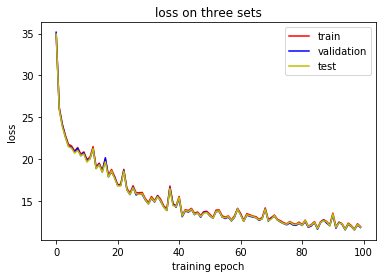

In [6]:
plt.figure(1)
ptr,=plt.plot(range(max_epoch),loss_train_his,'r-')
pva,=plt.plot(range(max_epoch),loss_val_his,'b-')
pte,=plt.plot(range(max_epoch),loss_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.title('loss on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.savefig('model-DRAW.png')
plt.show()

In [7]:
def draw_patch(image,_gx,_gy,_stride,_sigma):
    '''
    draw the attention boundary on the canvas
    width of edge reflects sigma
    '''
    fig = plt.figure(1)
    ax = fig.add_subplot(111, aspect='equal')
    plt.imshow(image,vmin=0,vmax=1,cmap='gray')
    upper_left_x=_gx-_stride*(patch-1)//2
    upper_left_y=_gy-_stride*(patch-1)//2
    width=_stride*(patch-1)
    height=_stride*(patch-1)
    rect = patches.Rectangle((upper_left_x,upper_left_y),width,height,linewidth=_sigma*3.0,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

INFO:tensorflow:Restoring parameters from parameters/DRAW/DRAW.ckpt
time = 0
gx = 17.691887
gy = 10.155741
stride = 1.7164845
sigma = 1.1931188


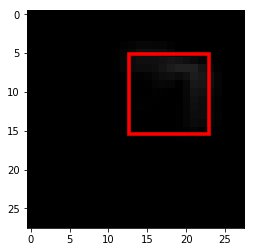

time = 1
gx = 17.104765
gy = 11.48263
stride = 2.141722
sigma = 0.95892894


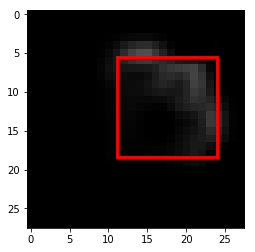

time = 2
gx = 16.746237
gy = 12.049476
stride = 2.138499
sigma = 0.96457326


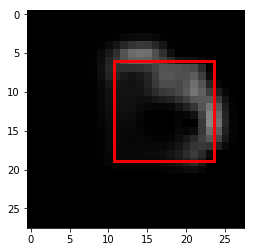

time = 3
gx = 15.942428
gy = 12.802816
stride = 2.3393629
sigma = 0.7835712


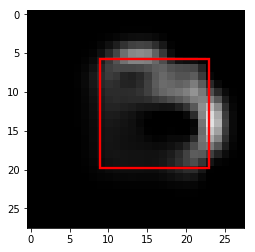

time = 4
gx = 16.393238
gy = 12.682791
stride = 2.0945554
sigma = 0.8561621


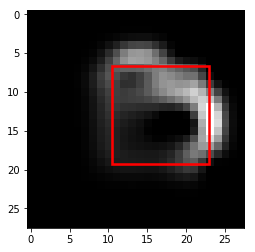

time = 5
gx = 15.017131
gy = 13.478482
stride = 2.3492763
sigma = 0.8345068


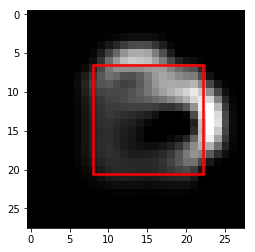

time = 6
gx = 14.442847
gy = 13.8927765
stride = 2.3399587
sigma = 0.87796706


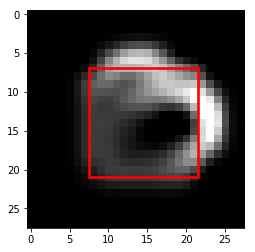

time = 7
gx = 13.937519
gy = 14.387347
stride = 2.2440908
sigma = 0.8767498


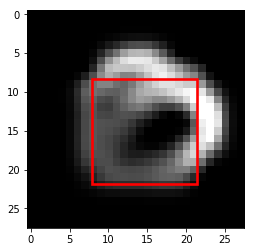

time = 8
gx = 13.372909
gy = 14.767207
stride = 2.2068708
sigma = 0.82100314


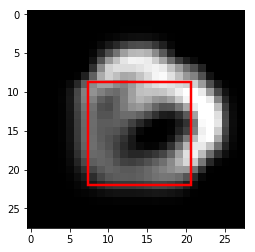

time = 9
gx = 12.79353
gy = 15.132955
stride = 2.1270626
sigma = 0.9161524


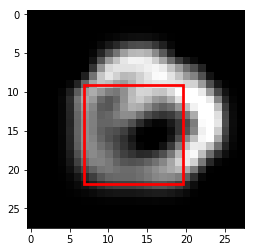

time = 10
gx = 12.060598
gy = 15.584583
stride = 2.0366004
sigma = 0.92099017


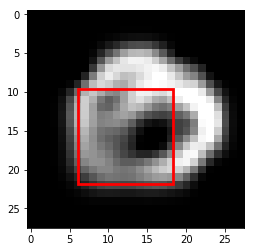

time = 11
gx = 11.2080145
gy = 16.24907
stride = 1.917633
sigma = 0.95699674


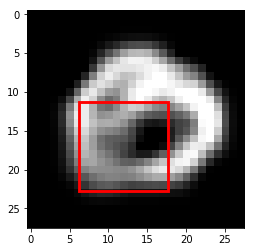

time = 12
gx = 10.507066
gy = 16.648806
stride = 1.912993
sigma = 1.0242323


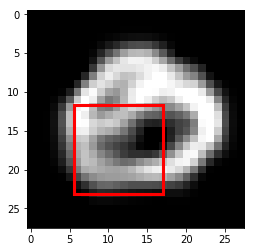

time = 13
gx = 10.12096
gy = 16.984028
stride = 1.8443285
sigma = 1.0482502


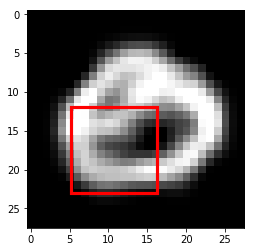

time = 14
gx = 9.553763
gy = 17.615438
stride = 1.7145373
sigma = 1.0659357


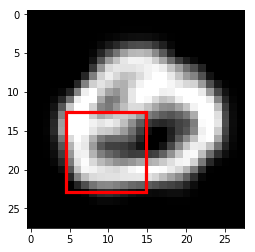

In [10]:
G_batch_size=tf.placeholder(shape=(),dtype=tf.int32,name='batch_size')
G_init_state_decode=decoder_lstm.zero_state(G_batch_size, tf.float32)
G_state_decode=None
G_unit_gaussian=tf.distributions.Normal(loc=tf.zeros((G_batch_size,latent_dim)),scale=tf.ones((G_batch_size,latent_dim)))
G_canvas=tf.zeros(shape=[G_batch_size,channel,height,width],dtype=tf.float32)

G_canvas_his=[]
G_write_paras_his=[]
for t in range(n_glimpse):
    G_Z=G_unit_gaussian.sample()
    with tf.variable_scope("LSTM_decoder") as vs:
        decoder_out,G_state_decode=decoder_lstm(G_Z,G_init_state_decode if t==0 else G_state_decode)
    _gx,_gy,_sigma,_stride,_gamma=decode_attention_para(decoder_out,WRITE_attention_paras)
    G_write_paras_his.append((_gx,_gy,_stride,_sigma))
    new_patch_image=WRITE_patch(decoder_out)
    _FX,_FY=filterbank(G_batch_size,_gx,_gy,_sigma,_stride)
    added_image=write(new_patch_image,G_batch_size,_FX,_FY,_gamma)
    G_canvas+=added_image
    G_canvas_his.append(G_canvas)

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "parameters/DRAW/DRAW.ckpt")
    output,paras=sess.run([G_canvas_his,G_write_paras_his],feed_dict={G_batch_size:1})
#     images,labels=mnist.test.next_batch(1)
#     plt.imshow(images.reshape(28,28),vmin=0,vmax=1,cmap='gray')
#     plt.show()
#     output,paras,temp=sess.run([canvas_his,write_paras_his,Z],feed_dict={X:images.reshape(-1,1,28,28)})
#     print(temp)
    for tt in range(n_glimpse):
        print('time =',tt)
        new_img=output[tt].reshape(28,28)
        para=paras[tt]
        print('gx =',para[0][0,0])
        print('gy =',para[1][0,0])
        print('stride =',para[2][0,0])
        print('sigma =',np.sqrt(para[3][0,0]))
#         print(np.min(new_img),np.max(new_img))
#         print(dd)
        draw_patch(new_img,para[0][0,0],para[1][0,0],para[2][0,0],np.sqrt(para[3][0,0]))

In [9]:
# w,b=WRITE_attention_paras.variables

# with tf.Session() as sess:
#     tf.global_variables_initializer().run()
#     saver.restore(sess, "parameters/DRAW/DRAW.ckpt")
#     w_out=sess.run(w)
#     b_out=sess.run(b)
#     print(w_out)